# Análisis de Clustering en Datos preprocesados con FFT
### Objetivo
Implementar análisis de clustering en el dominio de frecuencia para verificar si existe separación evidente entre las clases de daño (N1, N2, N3) usando pares sincronizados de señales (S2, S1).

### Contexto del Proyecto
#### Estado Actual
- Datos raw: 34 especímenes, cada uno con 1-3 mediciones (pares S1/S2)
- Etiquetas: nivel_damage.csv mapea especímenes → {N1: 18, N2: 12, N3: 4}

#### Concepto Clave
- **1 datapoint = 1 par (S2, S1)** de una medición sincronizada
- El daño se manifiesta en la **relación entre S2 y S1**, no en señales individuales
- S2 = excitación basal, S1 = respuesta estructural filtrada por el aislador

In [50]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# Configuración de plots
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

print("📦 Librerías cargadas correctamente")

📦 Librerías cargadas correctamente


## 📊 Paso 1: Cargar Pares de Señales (S2, S1)

En este paso cargamos las señales raw de vibración de cada espécimen como **pares sincronizados** (S2, S1).

### ¿Por qué emparejar S2 y S1?

En Structural Health Monitoring (SHM), un aislador sísmico funciona como un **sistema dinámico input-output**:

```
S2 (base) → [AISLADOR] → S1 (superior)
```

- **S2 (Sótano 2)**: Mide la vibración en la base del aislador (excitación)
- **S1 (Sótano 1)**: Mide la vibración sobre el aislador (respuesta filtrada)

**El daño NO se detecta mirando S1 o S2 por separado**, sino en **cómo cambia la relación entre ellos**:
- **Aislador sano**: Atenúa ciertas frecuencias (S1 < S2 en bandas específicas)
- **Aislador dañado**: Amplifica anómalamente, cambian frecuencias dominantes, aparecen armónicos

Por eso tratamos cada medición como **UN solo datapoint** = par (S2, S1).

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
# Importar función de utilidades
sys.path.append('../utils')

# Importar logger de métricas
from metrics_logger import ClusteringMetricsLogger

# Inicializar logger
RESULTS_FILE = '../../results/clustering_experiments.csv'
logger = ClusteringMetricsLogger(output_file=RESULTS_FILE)

print(f"📊 Logger inicializado: {RESULTS_FILE}")

📊 Logger inicializado: ../../results/clustering_experiments.csv


In [53]:
from clustering_utils import load_paired_signals

# Configurar rutas
SIGNALS_DIR = '../../data/Signals_Raw/'
LABELS_CSV = '../../data/nivel_damage.csv'

print("🔧 Configuración:")
print(f"   📂 Directorio de señales: {SIGNALS_DIR}")
print(f"   📋 Archivo de etiquetas: {LABELS_CSV}")
print(f"   🎯 Especímenes a cargar: Solo base (A1, A2, ... sin -2, -3)")

🔧 Configuración:
   📂 Directorio de señales: ../../data/Signals_Raw/
   📋 Archivo de etiquetas: ../../data/nivel_damage.csv
   🎯 Especímenes a cargar: Solo base (A1, A2, ... sin -2, -3)


In [54]:
# Cargar pares de señales (S2, S1)
paired_data = load_paired_signals(
    signals_dir=SIGNALS_DIR,
    labels_csv=LABELS_CSV,
    base_specimens_only=True,  # Solo especímenes base (1 medición por aislador)
    target_length=60000,       # Estandarizar a 60,000 muestras (10 min @ 100Hz)
    verbose=True               # Mostrar progreso detallado
)

print(f"\n✅ Pares cargados exitosamente: {len(paired_data)}")

📋 PASO 1: Cargando etiquetas...
   ✓ Cargadas etiquetas para 71 especímenes

📂 PASO 2: Escaneando directorio ../../data/Signals_Raw/...
   ✓ Filtrado a 51 especímenes base (sin variantes -2, -3)

🔄 PASO 3: Cargando pares (S2, S1)...
   ✓ A1: 60,000 muestras → 60,000 (sin cambios) | N1 | Tipo B
   ✓ A10: 60,000 muestras → 60,000 (sin cambios) | N2 | Tipo C
   ✓ A11: 60,000 muestras → 60,000 (sin cambios) | N2 | Tipo C
   ✓ A12: 60,000 muestras → 60,000 (sin cambios) | N1 | Tipo C
   ✓ A13: 60,000 muestras → 60,000 (sin cambios) | N1 | Tipo C
   ✓ A14: 60,000 muestras → 60,000 (sin cambios) | N1 | Tipo B
   ✓ A15: 93,999 muestras → 60,000 (truncada) | N1 | Tipo nan
   ✓ A16: 86,499 muestras → 60,000 (truncada) | N1 | Tipo nan
   ✓ A17: 119,099 muestras → 60,000 (truncada) | N1 | Tipo nan
   ✓ A18: 104,199 muestras → 60,000 (truncada) | N1 | Tipo nan
   ✓ A19: 104,399 muestras → 60,000 (truncada) | N1 | Tipo nan
   ✓ A2: 60,000 muestras → 60,000 (sin cambios) | N1 | Tipo B
   ✓ A20: 99,49

### 🔍 Inspección de los Datos Cargados

Verifiquemos la estructura de los datos cargados y confirmemos que todo está correcto.

In [55]:
# Inspeccionar el primer par cargado
print("📋 ESTRUCTURA DE UN PAR (ejemplo con el primer espécimen):")
print("=" * 60)

first_pair = paired_data[0]

print(f"🆔 Specimen ID: {first_pair['specimen_id']}")
print(f"🏷️  Nivel de daño: {first_pair['nivel_dano']}")
print(f"🔧 Tipo de aislador: {first_pair['tipo']}")
print(f"📏 Longitud original: {first_pair['original_length']:,} muestras")
print(f"\n📊 Señal S2 (Sótano 2 - Base):")
print(f"   Shape: {first_pair['signal_S2'].shape}")
print(f"   Ejes: [N-S, E-W, U-D]")
print(f"   Min: [{first_pair['signal_S2'][:, 0].min():.6f}, {first_pair['signal_S2'][:, 1].min():.6f}, {first_pair['signal_S2'][:, 2].min():.6f}]")
print(f"   Max: [{first_pair['signal_S2'][:, 0].max():.6f}, {first_pair['signal_S2'][:, 1].max():.6f}, {first_pair['signal_S2'][:, 2].max():.6f}]")

print(f"\n📊 Señal S1 (Sótano 1 - Superior):")
print(f"   Shape: {first_pair['signal_S1'].shape}")
print(f"   Ejes: [N-S, E-W, U-D]")
print(f"   Min: [{first_pair['signal_S1'][:, 0].min():.6f}, {first_pair['signal_S1'][:, 1].min():.6f}, {first_pair['signal_S1'][:, 2].min():.6f}]")
print(f"   Max: [{first_pair['signal_S1'][:, 0].max():.6f}, {first_pair['signal_S1'][:, 1].max():.6f}, {first_pair['signal_S1'][:, 2].max():.6f}]")

print("=" * 60)

📋 ESTRUCTURA DE UN PAR (ejemplo con el primer espécimen):
🆔 Specimen ID: A1
🏷️  Nivel de daño: N1
🔧 Tipo de aislador: B
📏 Longitud original: 60,000 muestras

📊 Señal S2 (Sótano 2 - Base):
   Shape: (60000, 3)
   Ejes: [N-S, E-W, U-D]
   Min: [-0.886049, -0.963544, -0.200376]
   Max: [1.150439, 1.084325, 0.165302]

📊 Señal S1 (Sótano 1 - Superior):
   Shape: (60000, 3)
   Ejes: [N-S, E-W, U-D]
   Min: [-0.243628, -0.296160, -0.221557]
   Max: [0.212175, 0.280202, 0.236469]


In [56]:
# Crear DataFrame resumen de todos los pares cargados
summary_df = pd.DataFrame([
    {
        'Specimen_ID': pair['specimen_id'],
        'Nivel_Dano': pair['nivel_dano'],
        'Tipo': pair['tipo'],
        'Long_Original': pair['original_length'],
        'Long_Estandarizada': pair['signal_S2'].shape[0]
    }
    for pair in paired_data
])

print("\n📊 RESUMEN DE TODOS LOS PARES CARGADOS:")
print(summary_df.to_string(index=False))

print(f"\n✅ PASO 1 COMPLETADO")
print(f"   • {len(paired_data)} pares (S2, S1) cargados y estandarizados")
print(f"   • Distribución: {summary_df['Nivel_Dano'].value_counts().to_dict()}")
print(f"   • Todas las señales estandarizadas a 60,000 muestras")


📊 RESUMEN DE TODOS LOS PARES CARGADOS:
Specimen_ID Nivel_Dano Tipo  Long_Original  Long_Estandarizada
         A1         N1    B          60000               60000
        A10         N2    C          60000               60000
        A11         N2    C          60000               60000
        A12         N1    C          60000               60000
        A13         N1    C          60000               60000
        A14         N1    B          60000               60000
        A15         N1  NaN          93999               60000
        A16         N1  NaN          86499               60000
        A17         N1  NaN         119099               60000
        A18         N1  NaN         104199               60000
        A19         N1  NaN         104399               60000
         A2         N1    B          60000               60000
        A20         N1  NaN          99499               60000
        A21         N1  NaN          99599               60000
        A22    

## 🔄 Paso 2: Aplicar FFT a cada Par (S2, S1)

En este paso transformamos las señales del **dominio temporal** al **dominio de frecuencia** usando la **Fast Fourier Transform (FFT)**.

### ¿Por qué aplicar FFT?

El análisis en el dominio de frecuencia es fundamental en Structural Health Monitoring porque:

1. **El daño estructural se manifiesta como cambios en frecuencias características**:
   - Un aislador dañado puede tener frecuencias naturales diferentes
   - Aparecen nuevos picos espectrales (armónicos) por degradación de materiales
   - Se reduce la atenuación en ciertas bandas de frecuencia

2. **La relación S1/S2 en frecuencia representa la función de transferencia H(f)**:
   ```
   H(f) = S1(f) / S2(f)
   ```
   - **Aislador sano**: H(f) < 1 en bandas específicas (atenúa vibración)
   - **Aislador dañado**: H(f) anómalo, cambia en forma o magnitud

3. **Permite detectar patrones que no son evidentes en el dominio temporal**:
   - Dos señales pueden verse "similares" en el tiempo pero tener espectros muy diferentes
   - El FFT descompone la señal en sus componentes de frecuencia elementales

### Implementación

Aplicaremos FFT a cada par (S2, S1) y extraeremos:
- **Frecuencias**: Array de 0 a 50 Hz (Nyquist frequency @ 100 Hz sampling rate)
- **Magnitudes**: `|FFT|` para cada eje (N-S, E-W, U-D)
- **Power Spectrum**: `|FFT|²` normalizado (energía por frecuencia)

In [57]:
# Importar función FFT de utilidades
from clustering_utils import apply_fft_to_pairs

# Aplicar FFT a todos los pares
fft_data = apply_fft_to_pairs(
    paired_data=paired_data,
    sampling_rate=100  # Hz (confirmado en archivos raw)
)

print(f"\n✅ FFT aplicado a {len(fft_data)} pares exitosamente")

🔄 PASO 2: Aplicando FFT a cada par (S2, S1)...
   ✓ A1: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A10: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A11: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A12: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A13: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A14: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A15: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A16: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A17: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.001

### 🔍 Inspección de Datos FFT

Verifiquemos que el FFT se aplicó correctamente inspeccionando la estructura de los datos.

In [72]:
# Inspeccionar estructura FFT del primer par
print("📋 ESTRUCTURA FFT DE UN PAR (ejemplo: primer espécimen):")
print("=" * 60)

first_fft = fft_data[0]

print(f"🆔 Specimen ID: {first_fft['specimen_id']}")
print(f"🏷️  Nivel de daño: {first_fft['nivel_dano']}")

# Información del FFT de S2
fft_s2 = first_fft['fft_S2']
print(f"\n📊 FFT de S2 (Base):")
print(f"   • Frecuencias shape: {fft_s2['freqs'].shape}")
print(f"   • Rango frecuencias: {fft_s2['freqs'][0]:.4f} - {fft_s2['freqs'][-1]:.2f} Hz")
print(f"   • Resolución: {fft_s2['freqs'][1] - fft_s2['freqs'][0]:.6f} Hz")
print(f"   • Magnitudes shape: {fft_s2['magnitudes'].shape} (freqs × 3 ejes)")
print(f"   • Power spectrum shape: {fft_s2['power_spectrum'].shape}")

# Información del FFT de S1
fft_s1 = first_fft['fft_S1']
print(f"\n📊 FFT de S1 (Superior):")
print(f"   • Frecuencias shape: {fft_s1['freqs'].shape}")
print(f"   • Magnitudes shape: {fft_s1['magnitudes'].shape}")
print(f"   • Power spectrum shape: {fft_s1['power_spectrum'].shape}")

print("\n✅ Estructura FFT validada correctamente")
print("=" * 60)

📋 ESTRUCTURA FFT DE UN PAR (ejemplo: primer espécimen):
🆔 Specimen ID: A1
🏷️  Nivel de daño: N1

📊 FFT de S2 (Base):
   • Frecuencias shape: (30000,)
   • Rango frecuencias: 0.0000 - 50.00 Hz
   • Resolución: 0.001667 Hz
   • Magnitudes shape: (30000, 3) (freqs × 3 ejes)
   • Power spectrum shape: (30000, 3)

📊 FFT de S1 (Superior):
   • Frecuencias shape: (30000,)
   • Magnitudes shape: (30000, 3)
   • Power spectrum shape: (30000, 3)

✅ Estructura FFT validada correctamente


### 📈 Visualización: Espectros FFT de Ejemplo

Ahora visualizaremos los espectros de magnitud para **validar** que el FFT se aplicó correctamente y para **explorar visualmente** las diferencias entre:
- S2 (base) vs S1 (superior) en un mismo espécimen
- Especímenes de diferentes niveles de daño (N1, N2, N3)

Seleccionaremos 1 espécimen de cada nivel de daño para comparar.

In [74]:
def plot_fft_specimen(pair: dict, freq_max: float = 20.0, y_max: float = 80.0, figsize: tuple = (15, 4)):
    """
    Plotea los espectros FFT de S2 vs S1 para un espécimen.
    
    Args:
        pair: Diccionario con datos FFT del espécimen
        freq_max: Frecuencia máxima a mostrar (Hz)
        y_max: Límite superior del eje Y (magnitud). Default: 80
        figsize: Tamaño de la figura
    """
    specimen_id = pair['specimen_id']
    nivel = pair['nivel_dano']
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(f'{nivel} - Espécimen {specimen_id}: Comparación S2 (Base) vs S1 (Superior)', 
                 fontsize=13, fontweight='bold')
    
    axis_names = ['N-S', 'E-W', 'U-D']
    freqs = pair['fft_S2']['freqs']
    freq_mask = freqs <= freq_max
    
    for idx, axis_name in enumerate(axis_names):
        ax = axes[idx]
        mag_s2 = pair['fft_S2']['magnitudes'][:, idx]
        mag_s1 = pair['fft_S1']['magnitudes'][:, idx]
        
        ax.plot(freqs[freq_mask], mag_s2[freq_mask], 
                label='S2 (Base)', color='red', alpha=0.7, linewidth=1.2)
        ax.plot(freqs[freq_mask], mag_s1[freq_mask], 
                label='S1 (Superior)', color='green', alpha=0.7, linewidth=1.2)
        
        ax.set_xlabel('Frecuencia (Hz)')
        ax.set_ylabel('Magnitud |FFT|')
        ax.set_title(f'Eje {axis_name}', fontweight='bold')
        ax.set_ylim(0, y_max)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def get_specimens_by_damage(fft_data: list, nivel: str, n: int = 3) -> list:
    """Obtiene hasta n especímenes de un nivel de daño específico."""
    specimens = [p for p in fft_data if p['nivel_dano'] == nivel]
    return specimens[:n]


def get_specimens_by_id(fft_data: list, specimen_ids: list) -> list:
    """Obtiene especímenes por sus IDs específicos."""
    specimens = [p for p in fft_data if p['specimen_id'] in specimen_ids]
    # Mantener el orden solicitado
    ordered = []
    for sid in specimen_ids:
        for s in specimens:
            if s['specimen_id'] == sid:
                ordered.append(s)
                break
    return ordered


print("Funciones de visualización definidas")

Funciones de visualización definidas


### Espectros N1 (Sin daño / Daño leve)

Especímenes N1 encontrados: ['A1', 'A2', 'A16', 'A51']



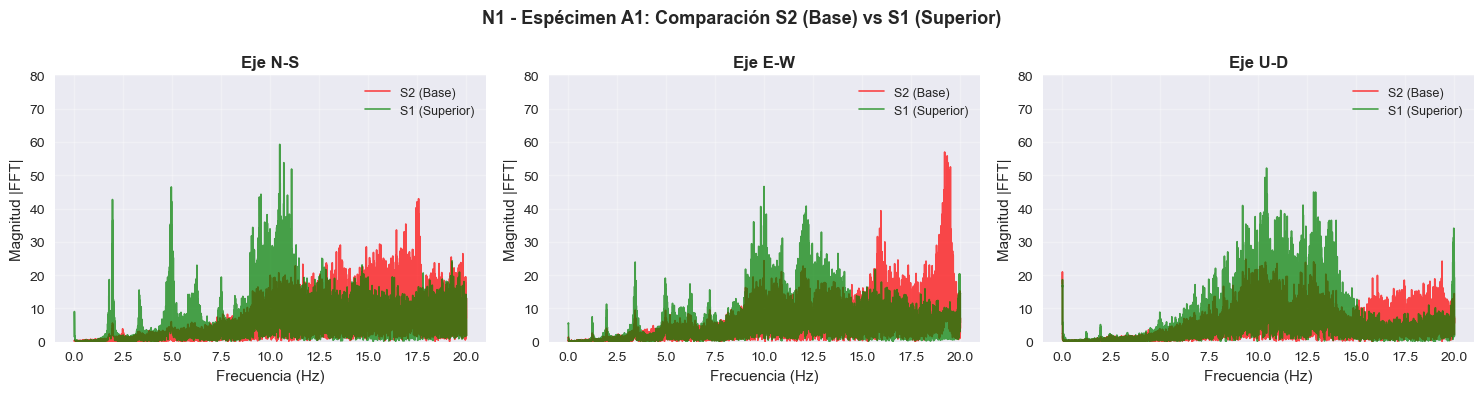

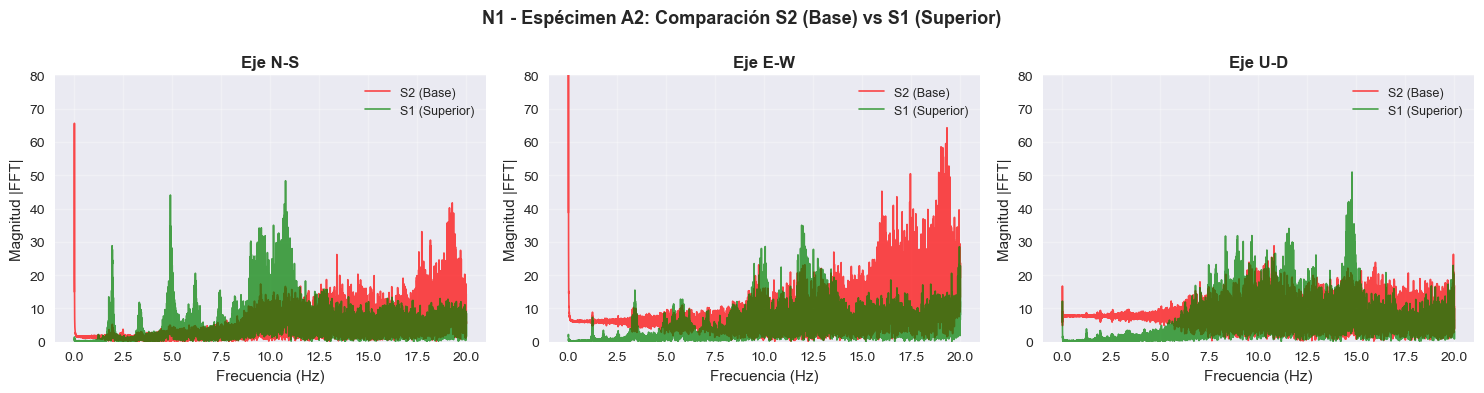

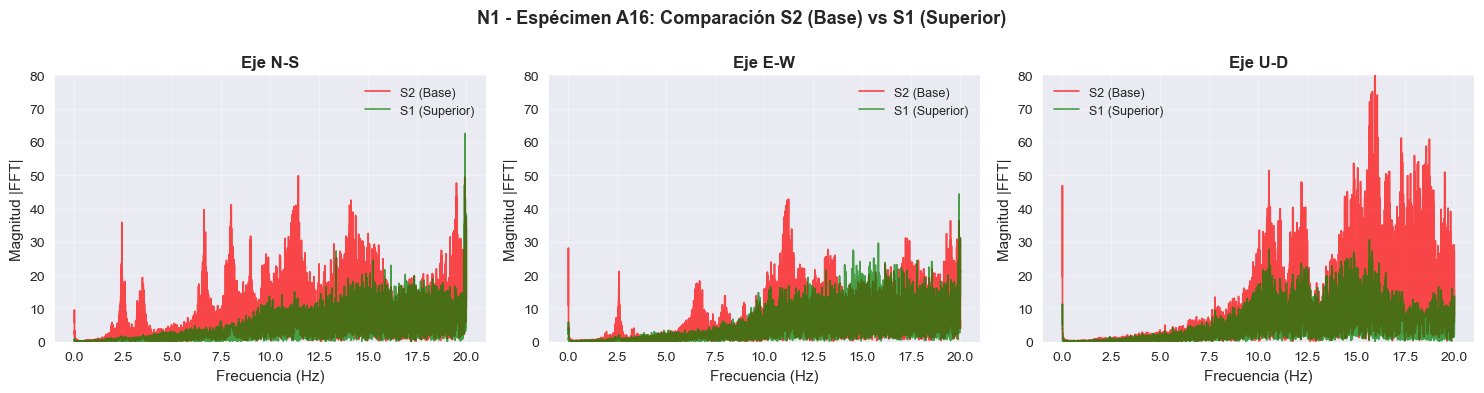

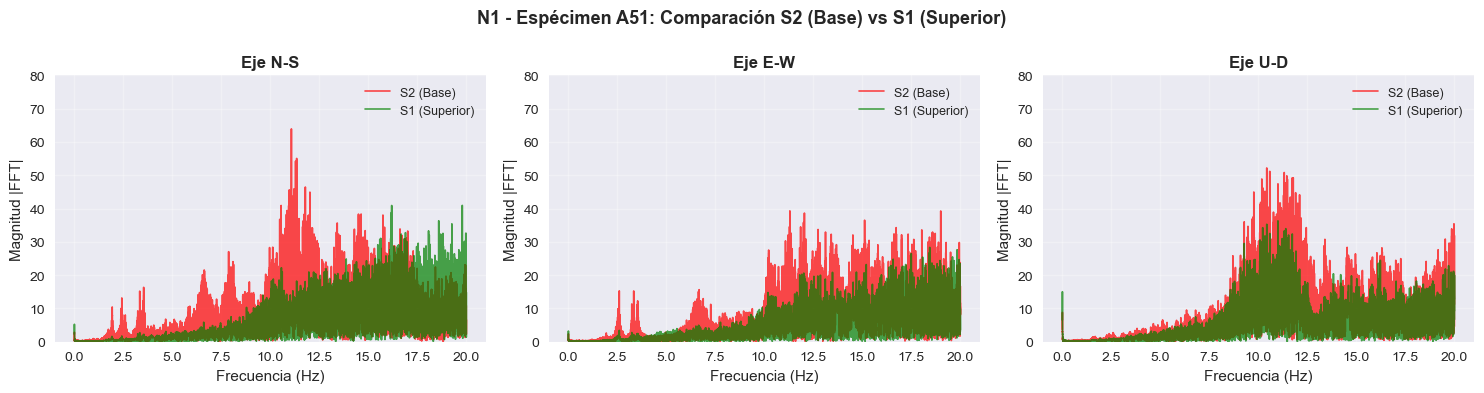

In [ ]:
# Visualizar 3 ejemplos de N1
# specimens_n1 = get_specimens_by_damage(fft_data, 'N1', n=3)
specimens_n1 = get_specimens_by_id(fft_data, ['A1','A2','A16','A51']) # 2 primer dataset, 2 ultimo dataset
print(f"Especímenes N1 encontrados: {[s['specimen_id'] for s in specimens_n1]}\n")

for specimen in specimens_n1:
    plot_fft_specimen(specimen)

### Espectros N2 (Daño moderado)

Especímenes N2 encontrados: ['A10', 'A11', 'A23']



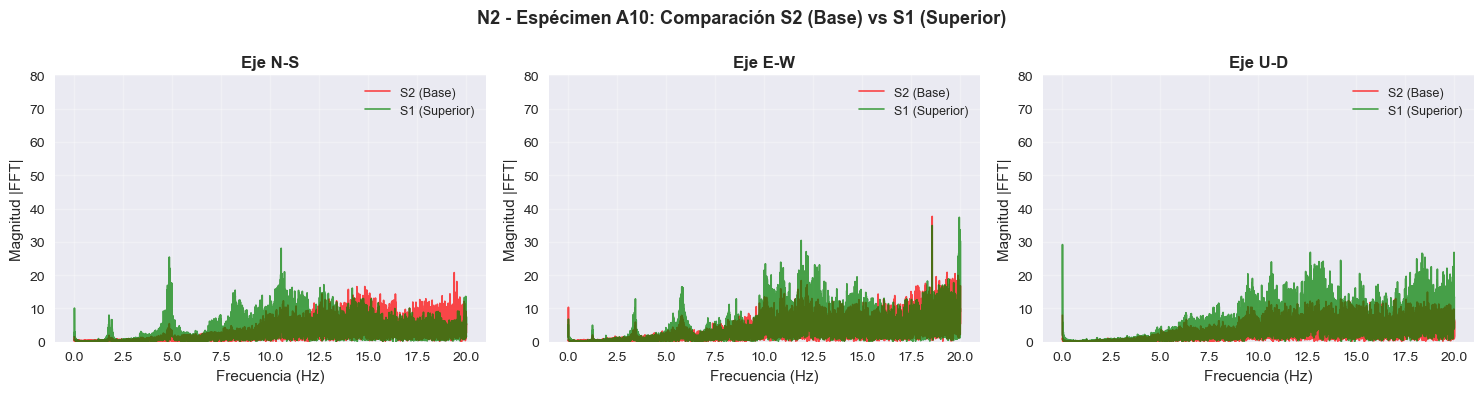

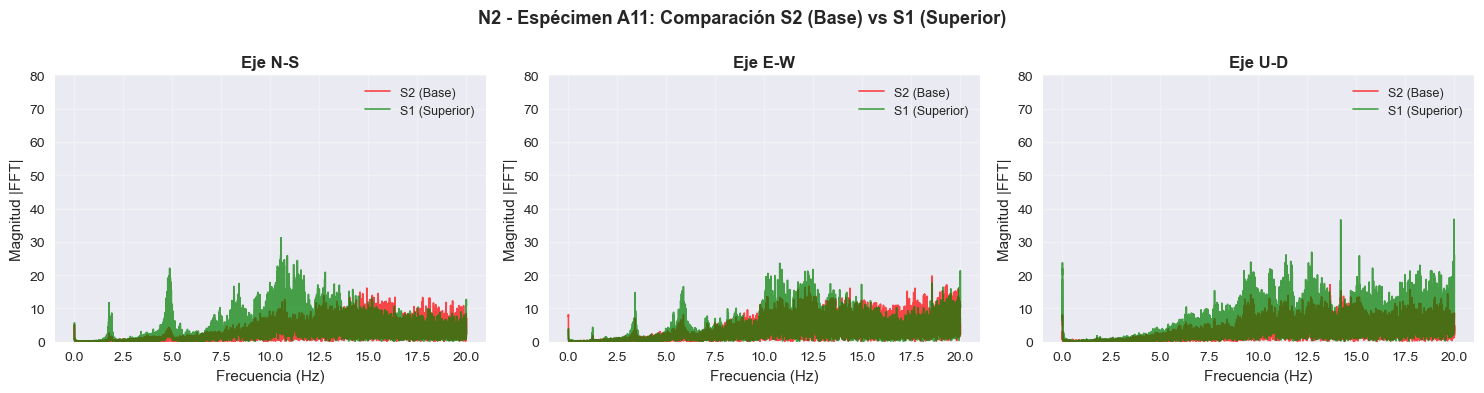

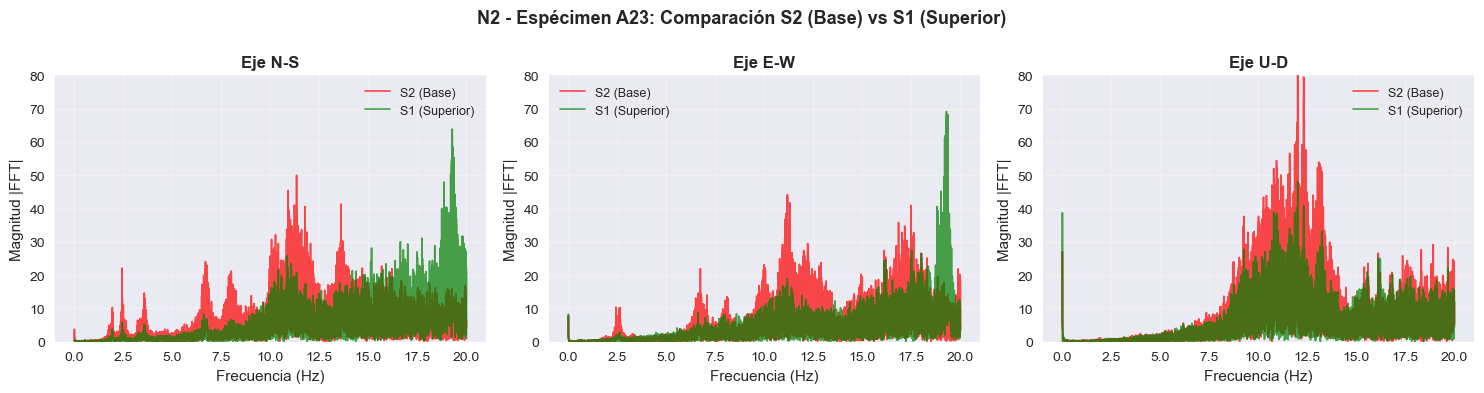

In [76]:
# Visualizar 3 ejemplos de N2
specimens_n2 = get_specimens_by_damage(fft_data, 'N2', n=3)
print(f"Especímenes N2 encontrados: {[s['specimen_id'] for s in specimens_n2]}\n")

for specimen in specimens_n2:
    plot_fft_specimen(specimen)

### Espectros N3 (Daño severo)

Especímenes N3 encontrados: ['A5', 'A6']



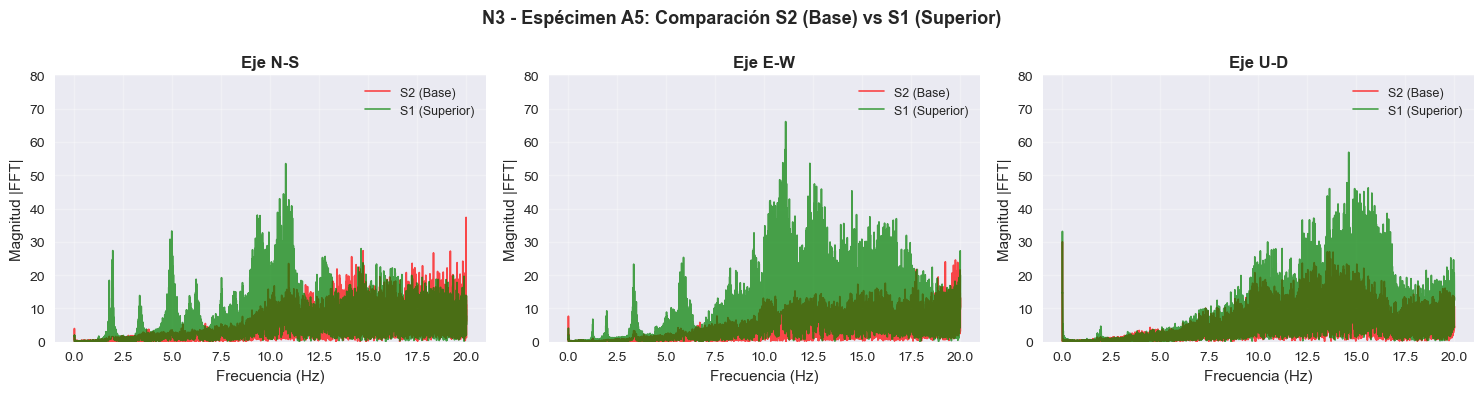

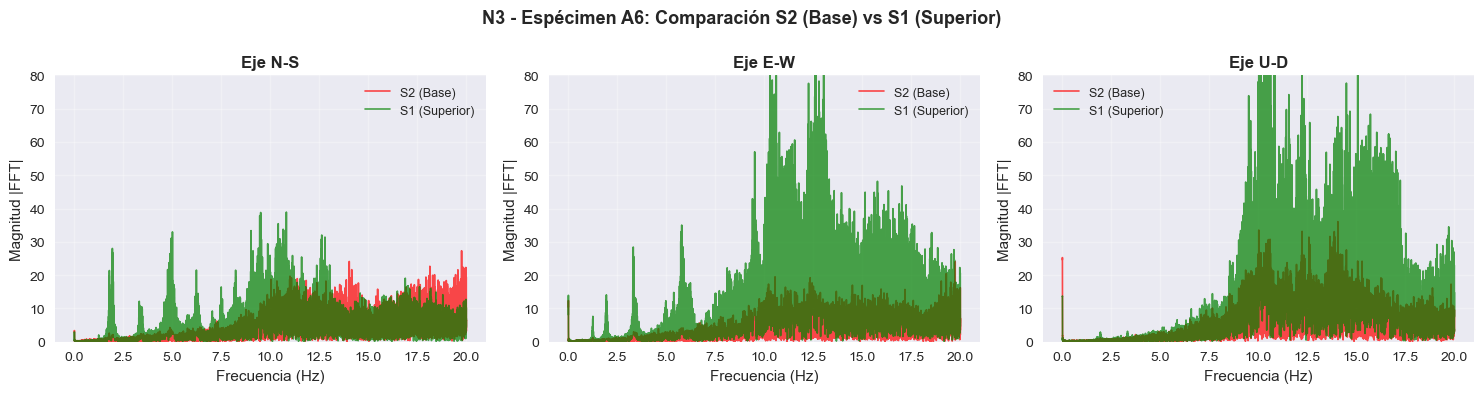

In [77]:
# Visualizar 3 ejemplos de N3
specimens_n3 = get_specimens_by_damage(fft_data, 'N3', n=3)
print(f"Especímenes N3 encontrados: {[s['specimen_id'] for s in specimens_n3]}\n")

for specimen in specimens_n3:
    plot_fft_specimen(specimen)

## ? [Conclusion cuestionable]
_Los espectros de frecuencia muestran una diferenciación consistente entre la señal registrada en la base (S2) y la señal medida en la parte superior del sistema de aislamiento (S1). Mientras que S2 presenta un contenido espectral más distribuido y con mayor presencia de altas frecuencias, S1 concentra su energía en un rango de bajas y medias frecuencias, lo cual evidencia el efecto de filtrado dinámico del aislador sísmico. Asimismo, conforme aumenta el nivel de daño, se observa un incremento de la energía espectral y una modificación de los picos dominantes en S1, lo que sugiere cambios en las propiedades dinámicas del sistema, tales como rigidez y amortiguamiento. Este comportamiento es más pronunciado en los ejes horizontales, confirmando su mayor sensibilidad para la detección de daño estructural._

#### Conclusión
    ✔️ Los gráficos son coherentes físicamente
    ✔️ Respaldan el uso de FFT como feature engineering
    ✔️ Justifican clasificación supervisada por niveles de daño
    ✔️ Sostienen la hipótesis S2 = excitación / S1 = respuesta

## 🎯 Paso 3: Extracción de Características Simples y Clustering

En lugar de extraer un conjunto extenso de características espectrales, vamos a empezar con un **enfoque minimalista** para ver cómo se separan los datos naturalmente.

### Características a extraer (18 total):

Para cada par (S2, S1) y cada eje (N-S, E-W, U-D):

1. **Frecuencia dominante** (6 valores): Dónde está el pico máximo del espectro
   - Indica la frecuencia de vibración más prominente
   
2. **Magnitud del pico** (6 valores): Qué tan intenso es ese pico
   - Indica la amplitud de la vibración dominante
   
3. **Energía total** (6 valores): Suma del power spectrum
   - Indica la energía total de vibración en todo el rango 0-20 Hz

**Resultado:** 30 datapoints (especímenes) × 18 características → matriz (30, 18) lista para clustering

In [78]:
# Importar función de extracción de features
from clustering_utils import extract_simple_spectral_features

# Extraer características espectrales simples
features_matrix, features_df, feature_names = extract_simple_spectral_features(
    fft_data=fft_data,
    freq_range=(0, 20)  # Rango relevante para estructuras civiles
)

print(f"\n📊 Matriz de features lista para clustering:")
print(f"   Shape: {features_matrix.shape}")
print(f"   {features_matrix.shape[0]} especímenes × {features_matrix.shape[1]} características")

🔄 Extrayendo características espectrales simples...
   Rango de frecuencias: 0 - 20 Hz
   ✓ A1 (N1): 18 features extraídas
   ✓ A10 (N2): 18 features extraídas
   ✓ A11 (N2): 18 features extraídas
   ✓ A12 (N1): 18 features extraídas
   ✓ A13 (N1): 18 features extraídas
   ✓ A14 (N1): 18 features extraídas
   ✓ A15 (N1): 18 features extraídas
   ✓ A16 (N1): 18 features extraídas
   ✓ A17 (N1): 18 features extraídas
   ✓ A18 (N1): 18 features extraídas
   ✓ A19 (N1): 18 features extraídas
   ✓ A2 (N1): 18 features extraídas
   ✓ A20 (N1): 18 features extraídas
   ✓ A21 (N1): 18 features extraídas
   ✓ A22 (N1): 18 features extraídas
   ✓ A23 (N2): 18 features extraídas
   ✓ A24 (N1): 18 features extraídas
   ✓ A25 (N2): 18 features extraídas
   ✓ A26 (N1): 18 features extraídas
   ✓ A27 (N1): 18 features extraídas
   ✓ A28 (N1): 18 features extraídas
   ✓ A29 (N1): 18 features extraídas
   ✓ A3 (N1): 18 features extraídas
   ✓ A30 (N1): 18 features extraídas
   ✓ A31 (N1): 18 features e

In [79]:
# Inspeccionar el DataFrame de features
print("📋 PRIMERAS 5 FILAS DEL DATAFRAME DE FEATURES:")
print(features_df.head().to_string())

print("\n📊 ESTADÍSTICAS DESCRIPTIVAS:")
print(features_df[feature_names].describe())

📋 PRIMERAS 5 FILAS DEL DATAFRAME DE FEATURES:
  tipo nivel_dano specimen_id  freq_dom_S2_NS  freq_dom_S2_EW  freq_dom_S2_UD  freq_dom_S1_NS  freq_dom_S1_EW  freq_dom_S1_UD  mag_peak_S2_NS  mag_peak_S2_EW  mag_peak_S2_UD  mag_peak_S1_NS  mag_peak_S1_EW  mag_peak_S1_UD  energy_S2_NS  energy_S2_EW  energy_S2_UD  energy_S1_NS  energy_S1_EW  energy_S1_UD
0    B         N1          A1       17.561667       19.196667        9.358333       42.941020       56.966391       24.805240       12.923618       12.784725        7.147410       10.476667        9.981667       10.418333     59.262653     46.603066     52.144062     15.425291     11.921611     17.036949
1    C         N2         A10       19.378333       18.561667       18.625000       20.750889       37.626348       14.899039        3.156308        4.175829        2.812143       10.551667       19.943333        0.005000     28.052539     37.355060     29.177434      3.899934      6.415647      8.181594
2    C         N2         A11       

### 📋 Explicación de las 18 Características (6 por eje)

Cada señal (S2 y S1) tiene **3 ejes de aceleración**:
- **N-S (Norte-Sur)**: Movimiento horizontal en dirección norte-sur
- **E-W (Este-Oeste)**: Movimiento horizontal en dirección este-oeste  
- **U-D (Arriba-Abajo)**: Movimiento vertical

Para cada eje se extraen **3 características espectrales**, resultando en **6 características por señal** (S2 o S1):

| Característica | Descripción | Ejemplo Columna |
|----------------|-------------|-----------------|
| **Frecuencia dominante** | Frecuencia donde ocurre el pico máximo del espectro FFT | `freq_dom_S2_NS` |
| **Magnitud del pico** | Intensidad (amplitud) del pico dominante | `mag_peak_S2_NS` |
| **Energía total** | Suma de la energía espectral en el rango 0-20 Hz | `energy_S2_NS` |

**Total por espécimen:**
- **S2** (base): 3 ejes × 3 características = **9 features**
- **S1** (superior): 3 ejes × 3 características = **9 features**
- **Total**: **18 características** por espécimen

### 🔬 Normalización de Features

Antes de aplicar clustering, necesitamos **normalizar** las características porque tienen escalas muy diferentes:
- Frecuencias: 0-20 Hz
- Magnitudes: pueden variar en varios órdenes de magnitud
- Energía: valores muy grandes

Usaremos **StandardScaler** (z-score normalization) para que todas las features tengan media=0 y std=1.

In [80]:
from sklearn.preprocessing import StandardScaler

# Normalizar features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_matrix)

print("📊 Features normalizadas:")
print(f"   Shape: {features_normalized.shape}")
print(f"   Media por feature: {features_normalized.mean(axis=0).mean():.6f} (≈0)")
print(f"   Std por feature: {features_normalized.std(axis=0).mean():.6f} (≈1)")
print(f"\n✅ Normalización completada")

📊 Features normalizadas:
   Shape: (51, 18)
   Media por feature: -0.000000 (≈0)
   Std por feature: 1.000000 (≈1)

✅ Normalización completada


### 📈 Método del Codo: Determinar Número Óptimo de Clusters

El **Método del Codo (Elbow Method)** es una técnica para determinar el número óptimo de clusters (k) en K-Means.

**¿Cómo funciona?**
- Ejecuta K-Means para diferentes valores de k (ej: 2, 3, 4, ..., 10)
- Calcula la inercia (WCSS = Within-Cluster Sum of Squares) para cada k
- Grafica k vs inercia
- Busca el "codo": el punto donde la inercia deja de disminuir significativamente

**Interpretación:**
- El "codo" indica el k óptimo
- Antes del codo: agregar clusters mejora mucho el agrupamiento
- Después del codo: agregar más clusters no aporta mejora significativa

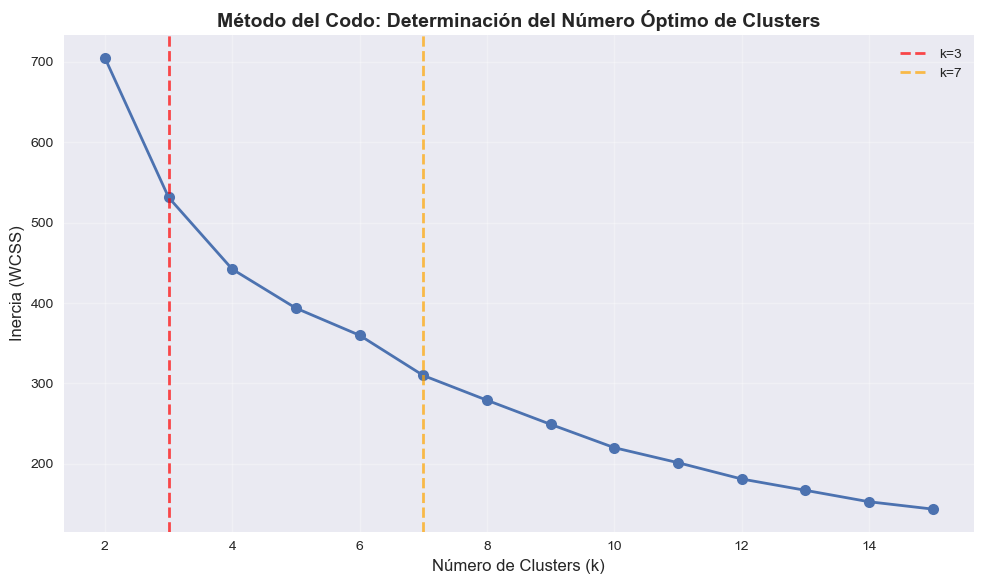

✅ Método del codo completado

📊 Interpretación:
   • Busca el 'codo' donde la inercia deja de disminuir significativamente
   • El codo indica el número óptimo de clusters
   • Inercia para k=3: 531.40
   • Inercia para k=7: 309.95


In [81]:
from sklearn.cluster import KMeans

# Calcular inercia para diferentes valores de k
k_range = range(2, 16)
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_normalized)
    inertias.append(kmeans.inertia_)

# Graficar método del codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o', linewidth=2, markersize=8)
plt.axvline(x=3, color='red', linestyle='--', linewidth=2, alpha=0.7, label='k=3')
plt.axvline(x=7, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='k=7')
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Inercia (WCSS)', fontsize=12)
plt.title('Método del Codo: Determinación del Número Óptimo de Clusters', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("✅ Método del codo completado")
print("\n📊 Interpretación:")
print("   • Busca el 'codo' donde la inercia deja de disminuir significativamente")
print("   • El codo indica el número óptimo de clusters")
print(f"   • Inercia para k=3: {inertias[1]:.2f}")
print(f"   • Inercia para k=7: {inertias[5]:.2f}")

### 📐 Reducción de Dimensionalidad con PCA

Para visualizar los 14 datapoints en 2D, aplicaremos **PCA (Principal Component Analysis)**:
- Reduce de 18 dimensiones a 2 dimensiones
- Preserva la máxima varianza posible
- Nos permite plotear y ver si hay separación natural entre N1, N2, N3

In [82]:
from sklearn.decomposition import PCA

# Aplicar PCA para reducir a 2D
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_normalized)

print("📊 PCA aplicado:")
print(f"   Shape original: {features_normalized.shape}")
print(f"   Shape reducida: {features_pca.shape}")
print(f"\n📈 Varianza explicada por componente:")
print(f"   PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"   PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"   Total: {pca.explained_variance_ratio_.sum():.2%}")
print(f"\n✅ Reducción de dimensionalidad completada")

📊 PCA aplicado:
   Shape original: (51, 18)
   Shape reducida: (51, 2)

📈 Varianza explicada por componente:
   PC1: 26.82%
   PC2: 21.99%
   Total: 48.80%

✅ Reducción de dimensionalidad completada


### 🎨 Visualización: Datos Reales en Espacio PCA

Antes de aplicar clustering, veamos cómo se distribuyen los especímenes/aisladores en el espacio 2D reducido, **coloreados por su etiqueta real** (N1, N2, N3).

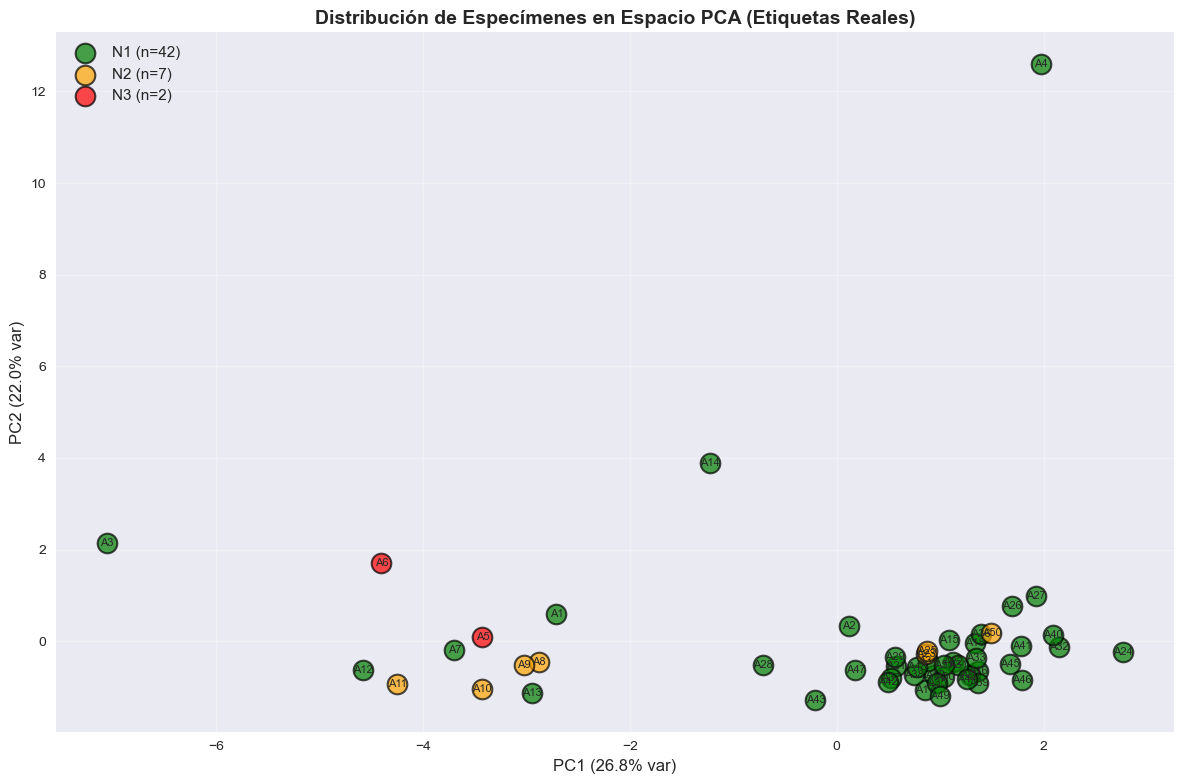

✅ Visualización completada

📊 OBSERVACIONES:
   • ¿Se agrupan naturalmente los especímenes del mismo nivel de daño?
   • ¿Hay solapamiento entre N1, N2, N3?
   • ¿Se observan outliers?


In [87]:
# Crear visualización de los datos reales en espacio PCA
fig, ax = plt.subplots(figsize=(12, 8))

# Colores por nivel de daño (incluyendo Sin_etiqueta)
colors = {'N1': 'green', 'N2': 'orange', 'N3': 'red', 'Sin_etiqueta': 'gray'}
labels_real = features_df['nivel_dano'].values
specimen_ids = features_df['specimen_id'].values

for nivel in ['N1', 'N2', 'N3', 'Sin_etiqueta']:
    mask = labels_real == nivel
    if mask.sum() == 0:  # Skip si no hay especímenes de este tipo
        continue
    
    ax.scatter(
        features_pca[mask, 0],
        features_pca[mask, 1],
        c=colors[nivel],
        label=f'{nivel} (n={mask.sum()})',
        s=200,
        alpha=0.7,
        edgecolors='black',
        linewidths=1.5
    )
    
    # Anotar IDs de especímenes
    for i, specimen_id in enumerate(specimen_ids[mask]):
        ax.annotate(
            specimen_id,
            (features_pca[mask, 0][i], features_pca[mask, 1][i]),
            fontsize=8,
            ha='center',
            va='center'
        )

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)', fontsize=12)
ax.set_title('Distribución de Especímenes en Espacio PCA (Etiquetas Reales)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualización completada")
print("\n📊 OBSERVACIONES:")
print("   • ¿Se agrupan naturalmente los especímenes del mismo nivel de daño?")
print("   • ¿Hay solapamiento entre N1, N2, N3?")
print("   • ¿Se observan outliers?")

### 🔍 Aplicar K-Means Clustering (k=3)

Ahora aplicaremos **K-Means** con k=3 clusters para ver si el algoritmo puede descubrir automáticamente grupos que coincidan con N1, N2, N3.

In [84]:
from sklearn.cluster import KMeans

# Aplicar K-Means con k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_normalized)

# Agregar etiquetas de cluster al DataFrame
features_df['cluster'] = cluster_labels

print("📊 K-Means aplicado:")
print(f"   Número de clusters: 3")
print(f"   Inercia (within-cluster sum of squares): {kmeans.inertia_:.2f}")
print(f"\n📈 Distribución de especímenes por cluster:")
print(features_df['cluster'].value_counts().sort_index())

print(f"\n📋 Comparación Cluster vs Nivel de Daño Real:")
comparison = pd.crosstab(features_df['nivel_dano'], features_df['cluster'], 
                         rownames=['Nivel Daño'], colnames=['Cluster'])
print(comparison)

📊 K-Means aplicado:
   Número de clusters: 3
   Inercia (within-cluster sum of squares): 531.40

📈 Distribución de especímenes por cluster:
cluster
0    38
1    12
2     1
Name: count, dtype: int64

📋 Comparación Cluster vs Nivel de Daño Real:
Cluster      0  1  2
Nivel Daño          
N1          35  6  1
N2           3  4  0
N3           0  2  0


### 🎨 Visualización: Clusters vs Etiquetas Reales

Comparación lado a lado de:
- **Izquierda**: Clusters descubiertos por K-Means
- **Derecha**: Etiquetas reales (N1, N2, N3)

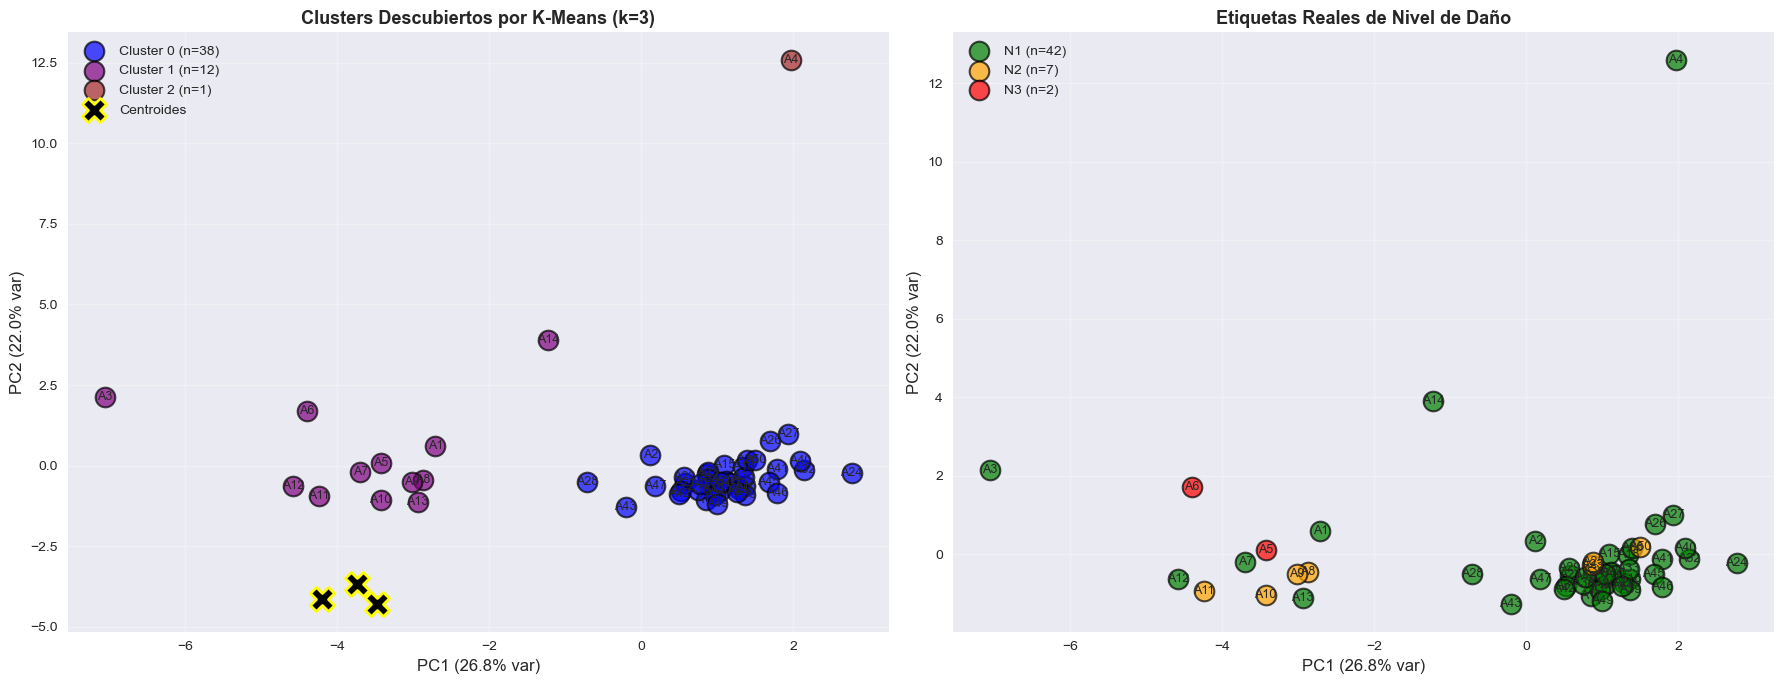

✅ Visualización completada

📊 INTERPRETACIÓN:
   • ¿Los clusters coinciden con los niveles de daño reales?
   • ¿Hay especímenes mal clasificados por K-Means?
   • ¿Qué nos dice esto sobre la separabilidad de N1, N2, N3?


In [88]:
# Visualización comparativa: Clusters vs Etiquetas Reales
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Clusters de K-Means
ax = axes[0]
cluster_colors = {0: 'blue', 1: 'purple', 2: 'brown'}

for cluster_id in range(3):
    mask = cluster_labels == cluster_id
    ax.scatter(
        features_pca[mask, 0],
        features_pca[mask, 1],
        c=cluster_colors[cluster_id],
        label=f'Cluster {cluster_id} (n={mask.sum()})',
        s=200,
        alpha=0.7,
        edgecolors='black',
        linewidths=1.5
    )
    
    # Anotar IDs
    for i, specimen_id in enumerate(specimen_ids[mask]):
        ax.annotate(
            specimen_id,
            (features_pca[mask, 0][i], features_pca[mask, 1][i]),
            fontsize=9,
            ha='center',
            va='center'
        )

# Plot centroides
centroids_pca = pca.transform(scaler.transform(kmeans.cluster_centers_))
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
           c='black', marker='X', s=300, 
           edgecolors='yellow', linewidths=2,
           label='Centroides', zorder=10)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)', fontsize=12)
ax.set_title('Clusters Descubiertos por K-Means (k=3)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)

# Plot 2: Etiquetas reales (incluyendo Sin_etiqueta)
ax = axes[1]
colors_real = {'N1': 'green', 'N2': 'orange', 'N3': 'red', 'Sin_etiqueta': 'gray'}

for nivel in ['N1', 'N2', 'N3', 'Sin_etiqueta']:
    mask = labels_real == nivel
    if mask.sum() == 0:  # Skip si no hay especímenes de este tipo
        continue
        
    ax.scatter(
        features_pca[mask, 0],
        features_pca[mask, 1],
        c=colors_real[nivel],
        label=f'{nivel} (n={mask.sum()})',
        s=200,
        alpha=0.7,
        edgecolors='black',
        linewidths=1.5
    )
    
    # Anotar IDs
    for i, specimen_id in enumerate(specimen_ids[mask]):
        ax.annotate(
            specimen_id,
            (features_pca[mask, 0][i], features_pca[mask, 1][i]),
            fontsize=9,
            ha='center',
            va='center'
        )

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)', fontsize=12)
ax.set_title('Etiquetas Reales de Nivel de Daño', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualización completada")
print("\n📊 INTERPRETACIÓN:")
print("   • ¿Los clusters coinciden con los niveles de daño reales?")
print("   • ¿Hay especímenes mal clasificados por K-Means?")
print("   • ¿Qué nos dice esto sobre la separabilidad de N1, N2, N3?")

### 📊 Métricas de Evaluación del Clustering

Evaluaremos la calidad del clustering usando métricas estándar.

In [89]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score

print("="*60)
print("📊 MÉTRICAS DE CLUSTERING")
print("="*60)

# --- Métricas INTRÍNSECAS (sin usar etiquetas reales) ---
print("\n🔹 MÉTRICAS INTRÍNSECAS (calidad interna del clustering):")
print("-"*60)

# Inertia (WCSS): [0, ∞) - más bajo es mejor
# Suma de distancias al cuadrado de cada punto a su centroide
inertia = kmeans.inertia_
print(f"   Inertia (WCSS):          {inertia:>8.2f}  (rango: 0 a ∞, óptimo: bajo)")

# Silhouette Score: [-1, 1] - más alto es mejor
# Mide qué tan similar es un punto a su propio cluster vs otros clusters
silhouette = silhouette_score(features_normalized, cluster_labels)
print(f"   Silhouette Score:        {silhouette:>8.4f}  (rango: -1 a 1, óptimo: ~1)")

# Davies-Bouldin Index: [0, ∞) - más bajo es mejor
# Mide la separación promedio entre clusters
davies_bouldin = davies_bouldin_score(features_normalized, cluster_labels)
print(f"   Davies-Bouldin Index:    {davies_bouldin:>8.4f}  (rango: 0 a ∞, óptimo: ~0)")

# Calinski-Harabasz Score: [0, ∞) - más alto es mejor
# Ratio de dispersión between-cluster vs within-cluster
calinski = calinski_harabasz_score(features_normalized, cluster_labels)
print(f"   Calinski-Harabasz:       {calinski:>8.2f}  (rango: 0 a ∞, óptimo: alto)")

# --- Métricas EXTRÍNSECAS (comparando con etiquetas reales) ---
print("\n🔹 MÉTRICAS EXTRÍNSECAS (comparación con etiquetas reales):")
print("-"*60)

# Filtrar solo especímenes CON etiqueta para métricas extrínsecas
label_mapping = {'N1': 0, 'N2': 1, 'N3': 2}
mask_con_etiqueta = labels_real != 'Sin_etiqueta'
labels_real_con_etiqueta = labels_real[mask_con_etiqueta]
cluster_labels_con_etiqueta = cluster_labels[mask_con_etiqueta]

# Convertir a numérico
labels_real_numeric = np.array([label_mapping[l] for l in labels_real_con_etiqueta])

print(f"   Evaluando sobre {len(labels_real_numeric)} de {len(labels_real)} especímenes (excluye Sin_etiqueta)")
print(f"-"*60)

if len(labels_real_numeric) > 0:
    # Adjusted Rand Index: [-1, 1] - más alto es mejor
    # Mide similitud entre dos particiones (ajustado por azar)
    ari = adjusted_rand_score(labels_real_numeric, cluster_labels_con_etiqueta)
    print(f"   Adjusted Rand Index:     {ari:>8.4f}  (rango: -1 a 1, óptimo: 1)")

    # Normalized Mutual Information: [0, 1] - más alto es mejor
    # Mide información compartida entre dos particiones
    nmi = normalized_mutual_info_score(labels_real_numeric, cluster_labels_con_etiqueta)
    print(f"   Normalized Mutual Info:  {nmi:>8.4f}  (rango: 0 a 1, óptimo: 1)")

    # Homogeneity: [0, 1] - más alto es mejor
    # Cada cluster contiene solo miembros de una sola clase
    homogeneity = homogeneity_score(labels_real_numeric, cluster_labels_con_etiqueta)
    print(f"   Homogeneity:             {homogeneity:>8.4f}  (rango: 0 a 1, óptimo: 1)")

    # Completeness: [0, 1] - más alto es mejor
    # Todos los miembros de una clase están asignados al mismo cluster
    completeness = completeness_score(labels_real_numeric, cluster_labels_con_etiqueta)
    print(f"   Completeness:            {completeness:>8.4f}  (rango: 0 a 1, óptimo: 1)")

    # V-Measure: [0, 1] - más alto es mejor
    # Media armónica de homogeneity y completeness
    v_measure = v_measure_score(labels_real_numeric, cluster_labels_con_etiqueta)
    print(f"   V-Measure:               {v_measure:>8.4f}  (rango: 0 a 1, óptimo: 1)")
else:
    print("   ⚠️ No hay especímenes con etiqueta para evaluar métricas extrínsecas")

print("\n" + "="*60)
print("📌 INTERPRETACIÓN:")
print("="*60)
print("• Métricas intrínsecas → calidad del clustering sin considerar etiquetas")
print("• Métricas extrínsecas → qué tan bien coincide con N1/N2/N3 reales")
print("• ARI/NMI cercanos a 0 → clustering no captura la estructura real")
print("• ARI/NMI cercanos a 1 → clustering coincide bien con etiquetas reales")
print("="*60)

📊 MÉTRICAS DE CLUSTERING

🔹 MÉTRICAS INTRÍNSECAS (calidad interna del clustering):
------------------------------------------------------------
   Inertia (WCSS):            531.40  (rango: 0 a ∞, óptimo: bajo)
   Silhouette Score:          0.3965  (rango: -1 a 1, óptimo: ~1)
   Davies-Bouldin Index:      1.0294  (rango: 0 a ∞, óptimo: ~0)
   Calinski-Harabasz:          17.46  (rango: 0 a ∞, óptimo: alto)

🔹 MÉTRICAS EXTRÍNSECAS (comparación con etiquetas reales):
------------------------------------------------------------
   Evaluando sobre 51 de 51 especímenes (excluye Sin_etiqueta)
------------------------------------------------------------
   Adjusted Rand Index:       0.2980  (rango: -1 a 1, óptimo: 1)
   Normalized Mutual Info:    0.1935  (rango: 0 a 1, óptimo: 1)
   Homogeneity:               0.2068  (rango: 0 a 1, óptimo: 1)
   Completeness:              0.1817  (rango: 0 a 1, óptimo: 1)
   V-Measure:                 0.1935  (rango: 0 a 1, óptimo: 1)

📌 INTERPRETACIÓN:
• Métr

### 📝 Registro del Experimento

Registramos todas las métricas y metadata del experimento en un archivo CSV para análisis comparativo posterior.

In [90]:
# Registrar experimento en CSV
logger.log_experiment(
    experiment_id="fft_kmeans_k3_simple",  # ID único para evitar duplicados
    notebook_name="2_clustering_fft_kmeans",
    algorithm="kmeans",
    frequency_transform="fft",
    n_clusters=3,
    pca_dims=2,
    feature_set="simple_spectral",
    
    # Métricas intrínsecas
    inertia=inertia,
    silhouette_score=silhouette,
    davies_bouldin_index=davies_bouldin,
    calinski_harabasz_score=calinski,
    
    # Métricas extrínsecas
    adjusted_rand_index=ari,
    normalized_mutual_info=nmi,
    homogeneity=homogeneity,
    completeness=completeness,
    v_measure=v_measure,
    
    # Metadata adicional
    n_samples=len(features_normalized),
    n_features=features_normalized.shape[1],
    notes="Baseline: FFT + features espectrales simples + K-Means k=3"
)

print(f"\n✅ Experimento registrado en: {RESULTS_FILE}")
print(f"📋 Para ver todos los experimentos, ejecuta:")
print(f"   pd.read_csv('{RESULTS_FILE}')")

🔄 Experimento actualizado: 2_clustering_fft_kmeans | kmeans | fft (ID: fft_kmeans_k3_simple)

✅ Experimento registrado en: ../../results/clustering_experiments.csv
📋 Para ver todos los experimentos, ejecuta:
   pd.read_csv('../../results/clustering_experiments.csv')


## 🧊 Experimento 2: K-Means con PCA 3D

Repetimos el clustering pero reduciendo a **3 dimensiones** para capturar más varianza.

In [91]:
# PCA a 3 dimensiones
pca_3d = PCA(n_components=3)
features_pca_3d = pca_3d.fit_transform(features_normalized)

print(f"📊 PCA 3D: varianza explicada = {pca_3d.explained_variance_ratio_.sum():.2%}")
print(f"   PC1: {pca_3d.explained_variance_ratio_[0]:.2%}")
print(f"   PC2: {pca_3d.explained_variance_ratio_[1]:.2%}")
print(f"   PC3: {pca_3d.explained_variance_ratio_[2]:.2%}")

# K-Means sobre features originales (mismo que antes)
kmeans_3d = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels_3d = kmeans_3d.fit_predict(features_normalized)

📊 PCA 3D: varianza explicada = 59.11%
   PC1: 26.82%
   PC2: 21.99%
   PC3: 10.30%


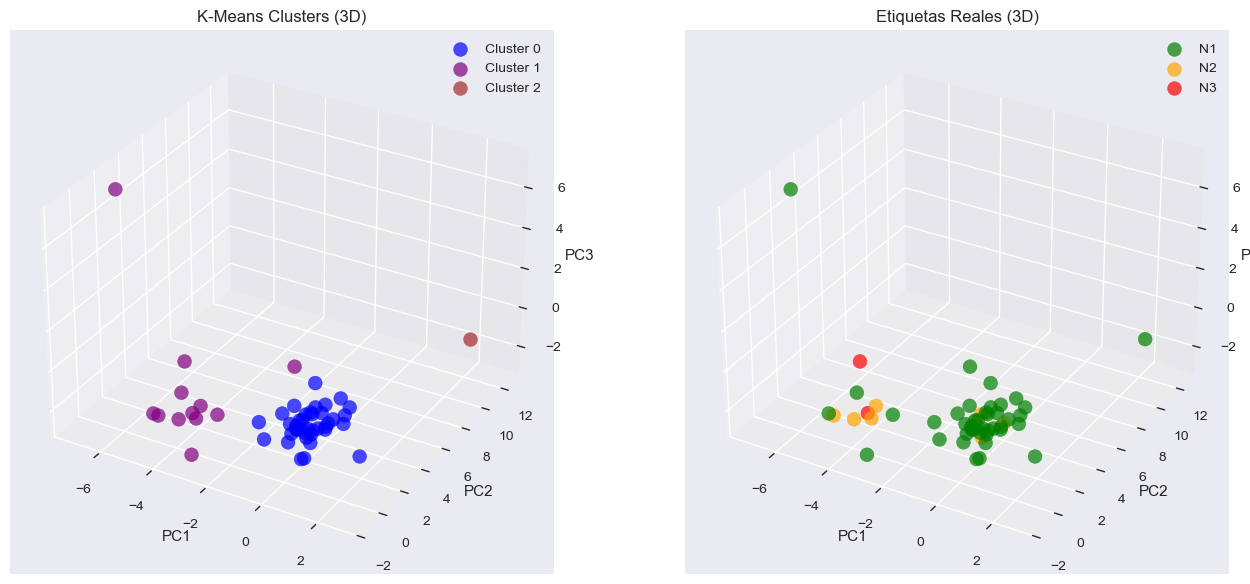

In [92]:
# Visualización 3D interactiva
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 6))

# Plot 1: Clusters
ax1 = fig.add_subplot(121, projection='3d')
cluster_colors_3d = {0: 'blue', 1: 'purple', 2: 'brown'}
for c in range(3):
    mask = cluster_labels_3d == c
    ax1.scatter(features_pca_3d[mask, 0], features_pca_3d[mask, 1], features_pca_3d[mask, 2],
                c=cluster_colors_3d[c], label=f'Cluster {c}', s=100, alpha=0.7)
ax1.set_xlabel('PC1'); ax1.set_ylabel('PC2'); ax1.set_zlabel('PC3')
ax1.set_title('K-Means Clusters (3D)')
ax1.legend()

# Plot 2: Etiquetas reales
ax2 = fig.add_subplot(122, projection='3d')
for nivel in ['N1', 'N2', 'N3', 'Sin_etiqueta']:
    mask = labels_real == nivel
    if mask.sum() == 0:
        continue
    ax2.scatter(features_pca_3d[mask, 0], features_pca_3d[mask, 1], features_pca_3d[mask, 2],
                c=colors_real[nivel], label=f'{nivel}', s=100, alpha=0.7)
ax2.set_xlabel('PC1'); ax2.set_ylabel('PC2'); ax2.set_zlabel('PC3')
ax2.set_title('Etiquetas Reales (3D)')
ax2.legend()

plt.tight_layout()
plt.show()

In [93]:
# Métricas y registro del experimento 3D
silhouette_3d = silhouette_score(features_normalized, cluster_labels_3d)
davies_bouldin_3d = davies_bouldin_score(features_normalized, cluster_labels_3d)
calinski_3d = calinski_harabasz_score(features_normalized, cluster_labels_3d)

# Métricas extrínsecas (solo especímenes con etiqueta)
cluster_labels_3d_con_etiqueta = cluster_labels_3d[mask_con_etiqueta]
ari_3d = adjusted_rand_score(labels_real_numeric, cluster_labels_3d_con_etiqueta)
nmi_3d = normalized_mutual_info_score(labels_real_numeric, cluster_labels_3d_con_etiqueta)
homogeneity_3d = homogeneity_score(labels_real_numeric, cluster_labels_3d_con_etiqueta)
completeness_3d = completeness_score(labels_real_numeric, cluster_labels_3d_con_etiqueta)
v_measure_3d = v_measure_score(labels_real_numeric, cluster_labels_3d_con_etiqueta)

print(f"📊 Métricas PCA 3D:")
print(f"   Silhouette: {silhouette_3d:.4f} (2D: {silhouette:.4f})")
print(f"   ARI: {ari_3d:.4f} (2D: {ari:.4f})")

# Registrar experimento
logger.log_experiment(
    experiment_id="fft_kmeans_k3_simple_3d",
    notebook_name="2_clustering_fft_kmeans",
    algorithm="kmeans",
    frequency_transform="fft",
    n_clusters=3,
    pca_dims=3,
    feature_set="simple_spectral",
    inertia=kmeans_3d.inertia_,
    silhouette_score=silhouette_3d,
    davies_bouldin_index=davies_bouldin_3d,
    calinski_harabasz_score=calinski_3d,
    adjusted_rand_index=ari_3d,
    normalized_mutual_info=nmi_3d,
    homogeneity=homogeneity_3d,
    completeness=completeness_3d,
    v_measure=v_measure_3d,
    n_samples=len(features_normalized),
    n_features=features_normalized.shape[1],
    notes="FFT + K-Means k=3 + PCA 3D"
)

📊 Métricas PCA 3D:
   Silhouette: 0.3965 (2D: 0.3965)
   ARI: 0.2980 (2D: 0.2980)
🔄 Experimento actualizado: 2_clustering_fft_kmeans | kmeans | fft (ID: fft_kmeans_k3_simple_3d)
